<a href="https://colab.research.google.com/github/FickleVaibhav/RespiScope-AI-Final/blob/main/respiratory_final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os
import shutil
import wave
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt
from IPython.display import Audio
import librosa
import librosa.display
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.layers import Conv1D, Conv2D, SeparableConv1D, MaxPooling1D, MaxPooling2D
from tensorflow.keras.layers import Input, add, Flatten, Dense, BatchNormalization, Dropout, LSTM, GRU
from tensorflow.keras.layers import GlobalMaxPooling1D, GlobalMaxPooling2D, Activation, LeakyReLU, ReLU
from tensorflow.keras import regularizers
from tensorflow.keras import backend as K
from tensorflow.keras.optimizers import Adamax
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score,precision_score,recall_score,f1_score,matthews_corrcoef
from sklearn.metrics import cohen_kappa_score,roc_auc_score,confusion_matrix,classification_report
from tensorflow.keras.models import Model

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
!cp '/content/drive/MyDrive/archive/' '/content'

cp: -r not specified; omitting directory '/content/drive/MyDrive/archive/'


In [4]:
!mkdir soundss

mkdir: cannot create directory ‘soundss’: File exists


In [5]:
!unzip /content/drive/MyDrive/archive/ -d '/content/soundss'

unzip:  cannot find or open /content/drive/MyDrive/archive/, /content/drive/MyDrive/archive/.zip or /content/drive/MyDrive/archive/.ZIP.


In [6]:
diagnosis_df = pd.read_csv('/content/drive/MyDrive/archive/Respiratory_Sound_Database/Respiratory_Sound_Database/patient_diagnosis.csv', names=['patient_id', 'disease'])
diagnosis_df.head()


patient_id  disease
0         101     URTI
1         102  Healthy
2         103   Asthma
3         104     COPD
4         105     URTI

In [7]:
print (diagnosis_df.disease.value_counts())
print ('')
print (diagnosis_df.disease.value_counts(normalize=True) *100)

disease
COPD              64
Healthy           26
URTI              14
Bronchiectasis     7
Bronchiolitis      6
Pneumonia          6
LRTI               2
Asthma             1
Name: count, dtype: int64

disease
COPD              50.793651
Healthy           20.634921
URTI              11.111111
Bronchiectasis     5.555556
Bronchiolitis      4.761905
Pneumonia          4.761905
LRTI               1.587302
Asthma             0.793651
Name: proportion, dtype: float64


In [12]:
import IPython.display as ipd
ipd.display(ipd.Audio('/content/drive/MyDrive/archive/Respiratory_Sound_Database/Respiratory_Sound_Database/audio_and_txt_files/117_1b3_Tc_mc_LittC2SE.wav', rate=7000))

(array([ 0., 10., 20., 30., 40., 50., 60., 70.]),
 [Text(0.0, 0, '0'),
  Text(10.0, 0, '10'),
  Text(20.0, 0, '20'),
  Text(30.0, 0, '30'),
  Text(40.0, 0, '40'),
  Text(50.0, 0, '50'),
  Text(60.0, 0, '60'),
  Text(70.0, 0, '70')])

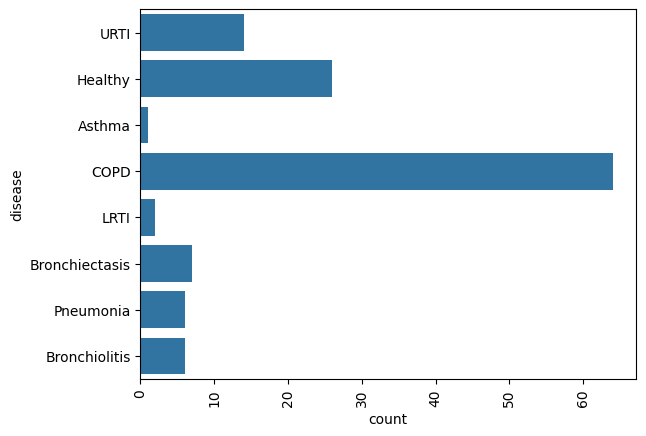

In [8]:
sns.countplot(diagnosis_df.disease)
plt.xticks(rotation=90)

In [9]:
path='/content/drive/MyDrive/archive/Respiratory_Sound_Database/Respiratory_Sound_Database/audio_and_txt_files/'
files=[s.split('.')[0] for s in os.listdir(path) if '.txt' in s]

In [10]:
files[:10]

['218_1b1_Ar_sc_Meditron',
 '218_1p1_Ar_sc_Litt3200',
 '217_1b1_Tc_sc_Meditron',
 '218_1b1_Pr_sc_Meditron',
 '216_1b1_Al_sc_Meditron',
 '218_1b1_Lr_sc_Meditron',
 '215_1b2_Ar_sc_Meditron',
 '218_1p1_Pl_sc_Litt3200',
 '220_1b1_Tc_mc_LittC2SE',
 '219_2b3_Tc_mc_LittC2SE']

In [11]:
def add_noise(data,x):
    noise = np.random.randn(len(data))
    data_noise = data + x * noise
    return data_noise

def shift(data,x):
    return np.roll(data, x)

def stretch(data, rate):
    data_stretched = librosa.effects.time_stretch(data, rate=rate)
    return data_stretched


def pitch_shift (data , rate):
    data = librosa.effects.pitch_shift(data, sr=220250, n_steps=rate)
    return data

In [12]:
def show_audio(audio_path):
    y, sr = librosa.load(audio_path)
    y_noise = add_noise(y , 0.0008)
    y_shift = shift(y,3200)
    y_stretch_1 = stretch(y, 1.2)
    y_stretch_2 = stretch(y, 0.8)
    y_pitch_shift = pitch_shift(y, 3)

    plt.figure(figsize=(20, 8))

    plt.subplot(3,2,1)
    librosa.display.waveshow(y, sr=sr)
    plt.title('orginal')

    plt.subplot(3,2,2)
    librosa.display.waveshow(y_noise, sr=sr)
    plt.title('noise')

    plt.subplot(3,2,3)
    librosa.display.waveshow(y_shift, sr=sr)
    plt.title('shift')

    plt.subplot(3,2,4)
    librosa.display.waveshow(y_stretch_1, sr=sr)
    plt.title('stretch 1')

    plt.subplot(3,2,5)
    librosa.display.waveshow(y_stretch_2, sr=sr)
    plt.title('stretch 2')

    plt.subplot(3,2,6)
    librosa.display.waveshow(y_pitch_shift, sr=sr)
    plt.title('pitch shift')

    plt.tight_layout()

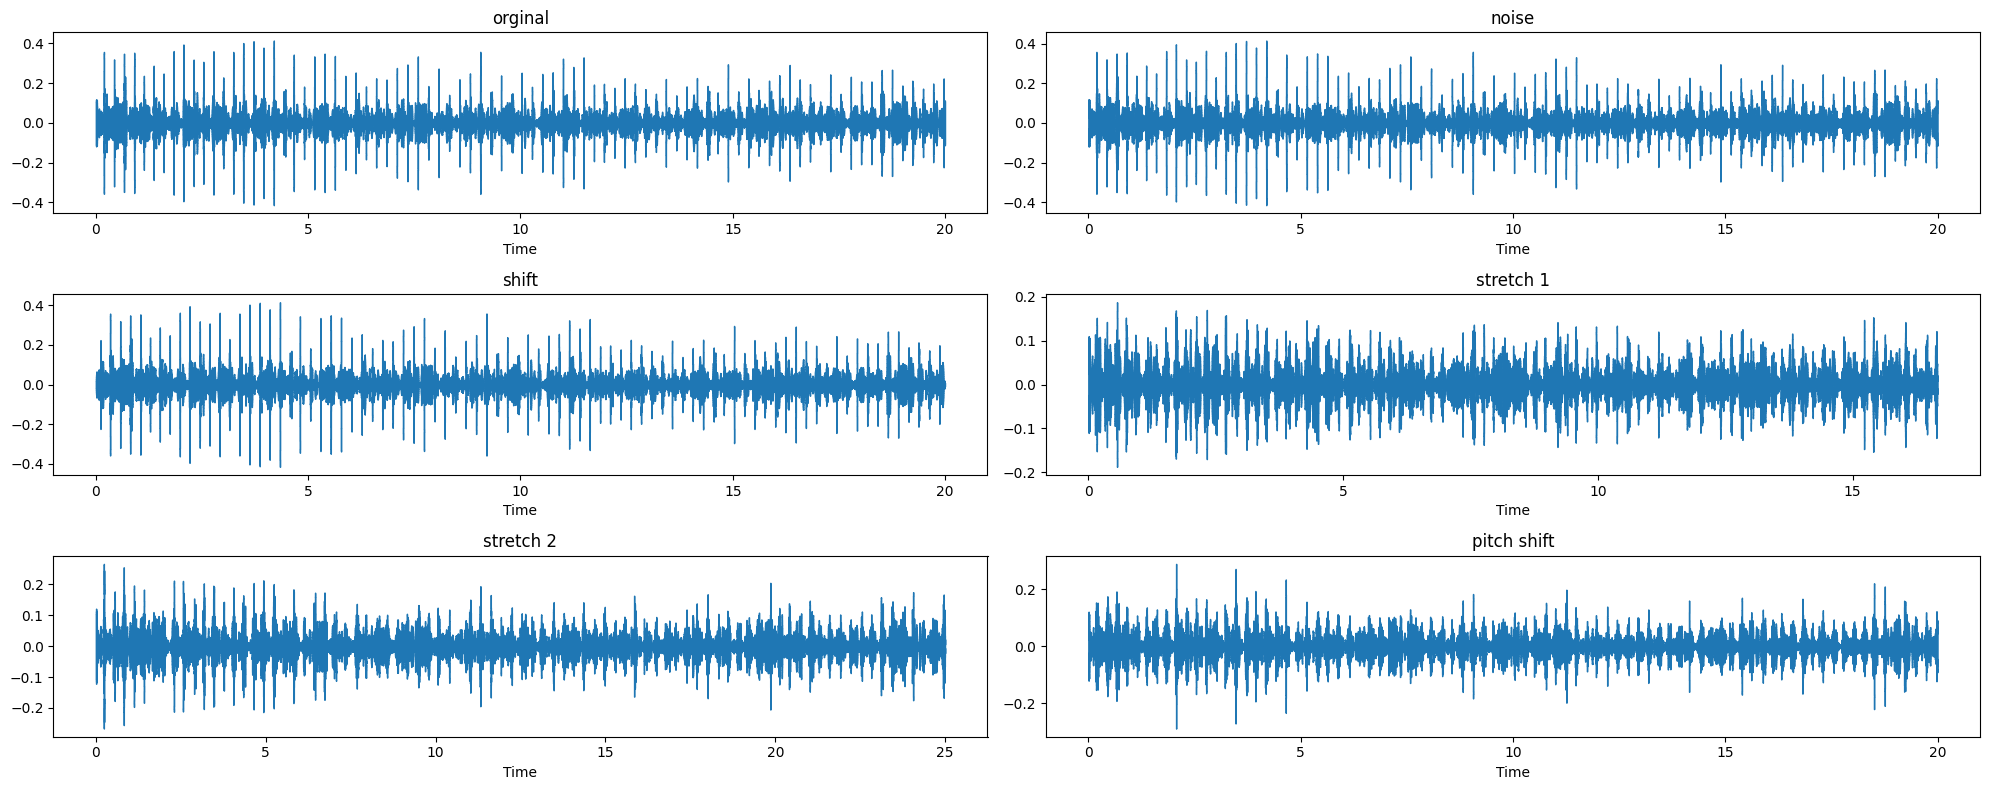

In [13]:
show_audio('/content/drive/MyDrive/archive/Respiratory_Sound_Database/Respiratory_Sound_Database/audio_and_txt_files/101_1b1_Al_sc_Meditron.wav')

In [14]:
def show_audio_features(audio_path):
    y, sr = librosa.load(audio_path)
    y_noise = add_noise(y , 0.0008)
    y_shift = shift(y,3200)
    y_stretch_1 = stretch(y, 1.2)
    y_stretch_2 = stretch(y, 0.8)
    y_pitch_shift = pitch_shift(y, 3)

    y = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=50)
    y_noise = librosa.feature.mfcc(y=y_noise, sr=sr, n_mfcc=50)
    y_shift = librosa.feature.mfcc(y=y_shift, sr=sr, n_mfcc=50)
    y_stretch_1 = librosa.feature.mfcc(y=y_stretch_1, sr=sr, n_mfcc=50)
    y_stretch_2 = librosa.feature.mfcc(y=y_stretch_2, sr=sr, n_mfcc=50)
    y_pitch_shift = librosa.feature.mfcc(y=y_pitch_shift, sr=sr, n_mfcc=50)

    plt.figure(figsize=(20, 8))

    plt.subplot(3,2,1)
    librosa.display.specshow(librosa.power_to_db(y,ref=np.max),
                             y_axis='mel',
                             fmax=8000,
                             x_axis='time')
    plt.colorbar(format='%+2.0f dB')
    plt.title('orginal')

    plt.subplot(3,2,2)
    librosa.display.specshow(librosa.power_to_db(y_noise,ref=np.max),
                             y_axis='mel',
                             fmax=8000,
                             x_axis='time')
    plt.colorbar(format='%+2.0f dB')
    plt.title('noise')

    plt.subplot(3,2,3)
    librosa.display.specshow(librosa.power_to_db(y_shift,ref=np.max),
                             y_axis='mel',
                             fmax=8000,
                             x_axis='time')
    plt.colorbar(format='%+2.0f dB')
    plt.title('shift')

    plt.subplot(3,2,4)
    librosa.display.specshow(librosa.power_to_db(y_stretch_1,ref=np.max),
                             y_axis='mel',
                             fmax=8000,
                             x_axis='time')
    plt.colorbar(format='%+2.0f dB')
    plt.title('stretch 1')

    plt.subplot(3,2,5)
    librosa.display.specshow(librosa.power_to_db(y_stretch_2,ref=np.max),
                             y_axis='mel',
                             fmax=8000,
                             x_axis='time')
    plt.colorbar(format='%+2.0f dB')
    plt.title('stretch 2')

    plt.subplot(3,2,6)
    librosa.display.specshow(librosa.power_to_db(y_pitch_shift,ref=np.max),
                             y_axis='mel',
                             fmax=8000,
                             x_axis='time')
    plt.colorbar(format='%+2.0f dB')
    plt.title('pitch shift')



    plt.tight_layout()

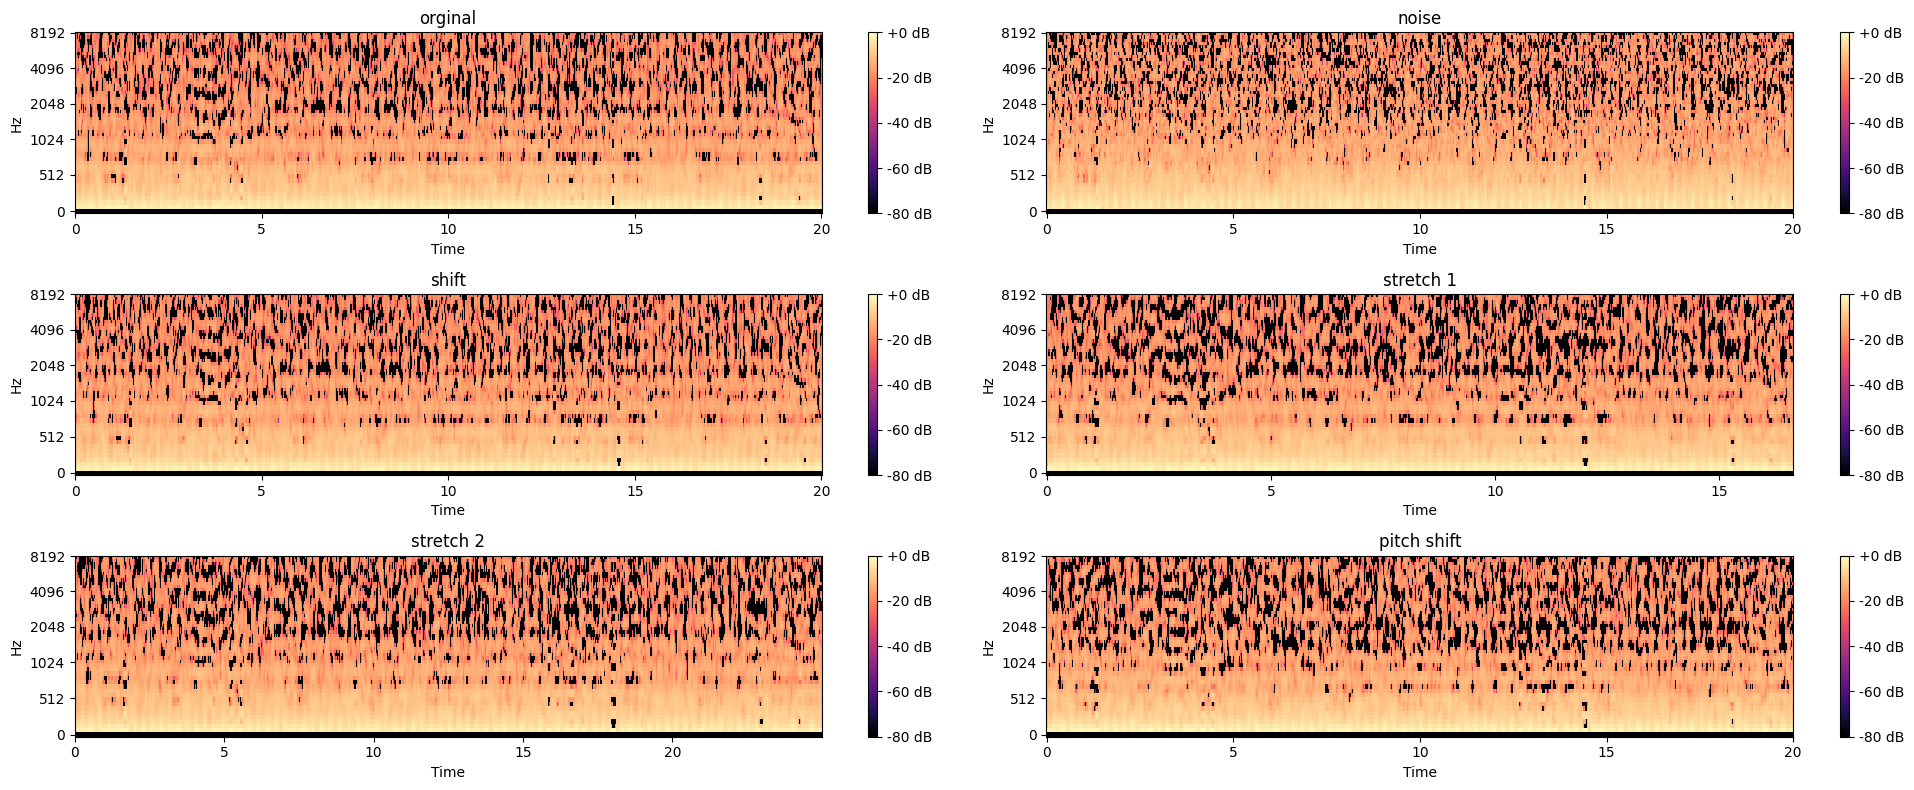

In [15]:
show_audio_features('/content/drive/MyDrive/archive/Respiratory_Sound_Database/Respiratory_Sound_Database/audio_and_txt_files/101_1b1_Al_sc_Meditron.wav')

In [22]:
def mfccs_feature_exteraction(dir_):
    '''
        Extract MFCC feature from the Sound data from the audio data.
        Augmentation of sound data by adding Noise, streaching and shifting.
        50 features are extracted from each audio data and used to train the model.
        Also, we remove .wav files with patient_id 103,108, and 115 to solve data imbalance, because they have unique lables.

        Args: dir_: Input directory to the Sound input file.

        Returns:
            X_data: Array of features extracted from the sound file.
            y_data: Array of target Labels.
    '''
    X_=[]
    y_=[]

    COPD=[]
    copd_count=0

    data = diagnosis_df
    features = 52

    for soundDir in (os.listdir(dir_)):
        # Check if the first three characters are digits before attempting conversion
        if soundDir[:3].isdigit() and soundDir[-3:]=='wav'and soundDir[:3]!='103'and soundDir[:3]!='108'and soundDir[:3]!='115':

            p = list(data[data['patient_id']==int(soundDir[:3])]['disease'])[0]
            if (p=='COPD'):
                if (soundDir[:6] in COPD) and copd_count<2:
                    data_x, sampling_rate = librosa.load(dir_+soundDir,res_type='kaiser_fast')
                    mfccs = np.mean(librosa.feature.mfcc(y=data_x, sr=sampling_rate, n_mfcc=features).T,axis=0)
                    COPD.append(soundDir[:6])
                    copd_count+=1
                    X_.append(mfccs)
                    y_.append(list(data[data['patient_id']==int(soundDir[:3])]['disease'])[0])

                if (soundDir[:6] not in COPD):
                    data_x, sampling_rate = librosa.load(dir_+soundDir,res_type='kaiser_fast')
                    mfccs = np.mean(librosa.feature.mfcc(y=data_x, sr=sampling_rate, n_mfcc=features).T,axis=0)
                    COPD.append(soundDir[:6])
                    copd_count=0
                    X_.append(mfccs)
                    y_.append(list(data[data['patient_id']==int(soundDir[:3])]['disease'])[0])

            if (p!='COPD'):
                if ((p == 'Bronchiectasis') or (p == 'Bronchiolitis')):
                    data_x, sampling_rate = librosa.load(dir_+soundDir,res_type='kaiser_fast')
                    mfccs = np.mean(librosa.feature.mfcc(y=data_x, sr=sampling_rate, n_mfcc=features).T,axis=0)
                    X_.append(mfccs)
                    y_.append('Bronchiolitis')

                    data_noise = add_noise(data_x,0.001)
                    mfccs_noise = np.mean(librosa.feature.mfcc(y=data_noise, sr=sampling_rate, n_mfcc=features).T,axis=0)
                    X_.append(mfccs_noise)
                    y_.append('Bronchiolitis')

                    data_shift = shift(data_x,1600)
                    mfccs_shift = np.mean(librosa.feature.mfcc(y=data_shift, sr=sampling_rate, n_mfcc=features).T,axis=0)
                    X_.append(mfccs_shift)
                    y_.append('Bronchiolitis')

                    data_stretch = stretch(data_x,1.2)
                    mfccs_stretch = np.mean(librosa.feature.mfcc(y=data_stretch, sr=sampling_rate, n_mfcc=features).T,axis=0)
                    X_.append(mfccs_stretch)
                    y_.append('Bronchiolitis')

                    data_stretch_2 = stretch(data_x,0.8)
                    mfccs_stretch_2 = np.mean(librosa.feature.mfcc(y=data_stretch_2, sr=sampling_rate, n_mfcc=features).T,axis=0)
                    X_.append(mfccs_stretch_2)
                    y_.append('Bronchiolitis')

                    data_pitch_shift = pitch_shift(data_x,3)
                    mfccs_stretch = np.mean(librosa.feature.melspectrogram(y=data_pitch_shift, sr=sampling_rate, n_mels=features).T,axis=0)
                    X_.append(mfccs_stretch)
                    y_.append('Bronchiolitis')

                else:
                    data_x, sampling_rate = librosa.load(dir_+soundDir,res_type='kaiser_fast')
                    mfccs = np.mean(librosa.feature.mfcc(y=data_x, sr=sampling_rate, n_mfcc=features).T,axis=0)
                    X_.append(mfccs)
                    y_.append(list(data[data['patient_id']==int(soundDir[:3])]['disease'])[0])

                    data_noise = add_noise(data_x,0.001)
                    mfccs_noise = np.mean(librosa.feature.mfcc(y=data_noise, sr=sampling_rate, n_mfcc=features).T,axis=0)
                    X_.append(mfccs_noise)
                    y_.append(p)

                    data_shift = shift(data_x,1600)
                    mfccs_shift = np.mean(librosa.feature.mfcc(y=data_shift, sr=sampling_rate, n_mfcc=features).T,axis=0)
                    X_.append(mfccs_shift)
                    y_.append(p)

                    data_stretch = stretch(data_x,1.2)
                    mfccs_stretch = np.mean(librosa.feature.mfcc(y=data_stretch, sr=sampling_rate, n_mfcc=features).T,axis=0)
                    X_.append(mfccs_stretch)
                    y_.append(p)

                    data_stretch_2 = stretch(data_x,0.8)
                    mfccs_stretch_2 = np.mean(librosa.feature.mfcc(y=data_stretch_2, sr=sampling_rate, n_mfcc=features).T,axis=0)
                    X_.append(mfccs_stretch_2)
                    y_.append(p)

                    data_pitch_shift = pitch_shift(data_x,3)
                    mfccs_stretch = np.mean(librosa.feature.melspectrogram(y=data_pitch_shift, sr=sampling_rate, n_mels=features).T,axis=0)
                    X_.append(mfccs_stretch)
                    y_.append(p)



    X_data = np.array(X_)
    y_data = np.array(y_)


    return X_data, y_data

In [17]:
!mkdir duplicates

mkdir: cannot create directory ‘duplicates’: File exists


In [18]:
!unzip /content/drive/MyDrive/duplicated_audio_data.zip -d '/content/duplicates'

Archive:  /content/drive/MyDrive/duplicated_audio_data.zip
replace /content/duplicates/157_1b1_Pr_sc_Meditron.wav? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [19]:
import os
import shutil

# Define the source and destination directories for the duplicated data
original_data_dir = '/content/drive/MyDrive/archive/Respiratory_Sound_Database/Respiratory_Sound_Database/audio_and_txt_files/'
duplicated_data_dir = '/content/duplicates/duplicated_audio_data/'

# Create the duplicated data directory if it doesn't exist
os.makedirs(duplicated_data_dir, exist_ok=True)

# Duplicate the audio files from the original directory to the duplicated directory
!cp -r "{original_data_dir}" "{duplicated_data_dir}"

In [ ]:
!pip uninstall librosa

Found existing installation: librosa 0.11.0
Uninstalling librosa-0.11.0:
  Would remove:
    /usr/local/lib/python3.12/dist-packages/librosa-0.11.0.dist-info/*
    /usr/local/lib/python3.12/dist-packages/librosa/*
  Would not remove (might be manually added):
    /usr/local/lib/python3.12/dist-packages/librosa/__pycache__/filters.__window_ss_fill-1520.py312.1.nbc
    /usr/local/lib/python3.12/dist-packages/librosa/__pycache__/filters.__window_ss_fill-1520.py312.nbi
    /usr/local/lib/python3.12/dist-packages/librosa/core/__pycache__/audio._zc_wrapper-1154.py312.1.nbc
    /usr/local/lib/python3.12/dist-packages/librosa/core/__pycache__/audio._zc_wrapper-1154.py312.2.nbc
    /usr/local/lib/python3.12/dist-packages/librosa/core/__pycache__/audio._zc_wrapper-1154.py312.nbi
    /usr/local/lib/python3.12/dist-packages/librosa/core/__pycache__/guf-audio._zc_wrapper-1154.py312.1.nbc
    /usr/local/lib/python3.12/dist-packages/librosa/core/__pycache__/guf-audio._zc_wrapper-1154.py312.2.nbc
    

In [40]:
!pip install librosa

In [41]:
!pip install resampy

In [45]:
!pip install --upgrade librosa

In [20]:
!pip install librosa==0.8.1
!pip install resampy

  Using cached librosa-0.8.1-py3-none-any.whl.metadata (6.8 kB)
Using cached librosa-0.8.1-py3-none-any.whl (203 kB)
  Attempting uninstall: librosa
    Found existing installation: librosa 0.11.0
    Uninstalling librosa-0.11.0:
      Successfully uninstalled librosa-0.11.0


In [23]:
x_mfccs, y = mfccs_feature_exteraction(duplicated_data_dir)

In [24]:
def augmented_lables_count(lables):
    unique, counts = np.unique(lables, return_counts=True)
    data_count = dict(zip(unique, counts))

    data = data_count

    courses = list(data.keys())
    values = list(data.values())

    fig = plt.figure(figsize = (10, 5))

    # creating the bar plot
    plt.bar(courses, values, color =['orange','green','blue','red','yellow','black'],
            width = 0.4)

    plt.xlabel("Diseases")
    plt.ylabel("Count")
    plt.title("Count of each disease")
    plt.show()

    print (data_count)

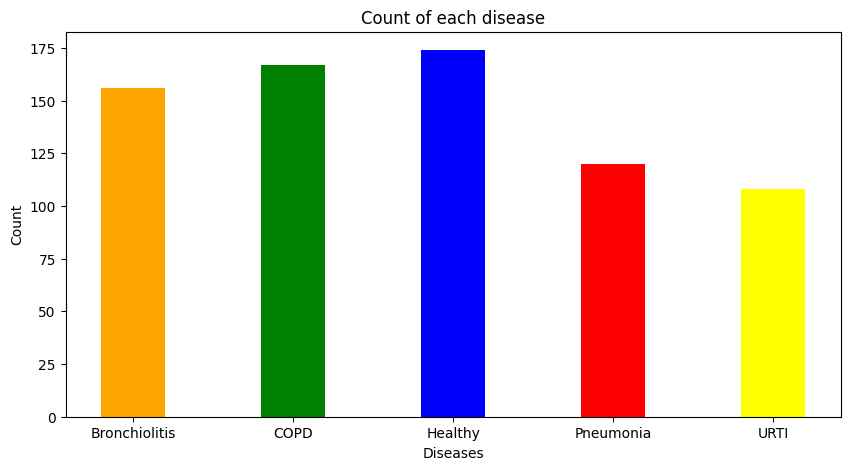

{np.str_('Bronchiolitis'): np.int64(156), np.str_('COPD'): np.int64(167), np.str_('Healthy'): np.int64(174), np.str_('Pneumonia'): np.int64(120), np.str_('URTI'): np.int64(108)}


In [25]:
augmented_lables_count(y)

In [26]:
y_data_encode = y.reshape(y.shape[0],1)
y_data_encode = np.where(y_data_encode == 'COPD',np.array([1,0,0,0,0]).reshape(1,5) , y_data_encode)
y_data_encode = np.where(y_data_encode == 'Bronchiolitis',np.array([0,1,0,0,0]).reshape(1,5) , y_data_encode)
y_data_encode = np.where(y_data_encode == 'Pneumonia',np.array([0,0,1,0,0]).reshape(1,5) , y_data_encode)
y_data_encode = np.where(y_data_encode == 'URTI',np.array([0,0,0,1,0]).reshape(1,5) , y_data_encode)
y_data_encode = np.where(y_data_encode == 'Healthy',np.array([0,0,0,0,1]).reshape(1,5) , y_data_encode)

Y_data = y_data_encode.astype('float64')


In [27]:
mfccs_features = np.array(x_mfccs)
lables = np.array(Y_data)

mfccs_features.shape , lables.shape

((725, 52), (725, 5))

In [28]:
mfcc_train, mfcc_test, lables_train, lables_test = train_test_split(mfccs_features, lables, test_size=0.1, random_state=10)
mfcc_train, mfcc_val, lables_train, lables_val = train_test_split(mfcc_train, lables_train, test_size=0.1, random_state=10)
print("Training set shape:", mfcc_train.shape, lables_train.shape)
print("Validation set shape:", mfcc_val.shape, lables_val.shape)
print("Test set shape:", mfcc_test.shape, lables_test.shape)

Training set shape: (586, 52) (586, 5)
Validation set shape: (66, 52) (66, 5)
Test set shape: (73, 52) (73, 5)


In [29]:
x_train_gru = np.expand_dims(mfcc_train,axis=1)
x_val_gru = np.expand_dims(mfcc_val,axis=1)
x_test_gru = np.expand_dims(mfcc_test,axis=1)

y_train_gru = np.expand_dims(lables_train,axis=1)
y_val_gru = np.expand_dims(lables_val,axis=1)
y_test_gru = np.expand_dims(lables_test,axis=1)


In [30]:
# from tensorflow.keras import layers, Sequential
# Input_Sample = Input(shape=(1,52))


# Model = Sequential([
#     layers.Conv1D(256, kernel_size=5, strides=1, padding='same', activation='relu')(Input_Sample),
#     layers.MaxPooling1D(pool_size=5, strides = 2, padding = 'same'),
#     layers.Conv1D(256, kernel_size=5, strides=1, padding='same', activation='relu'),
#     layers.MaxPooling1D(pool_size=5, strides = 2, padding = 'same'),
#     layers.Conv1D(128, kernel_size=5, strides=1, padding='same', activation='relu'),
#     layers.MaxPooling1D(pool_size=5, strides = 2, padding = 'same'),
#     layers.Conv1D(64, kernel_size=5, strides=1, padding='same', activation='relu'),
#     layers.MaxPooling1D(pool_size=5, strides = 2, padding = 'same'),
#     layers.Conv1D(32, kernel_size=5, strides=1, padding='same', activation='relu'),
#     layers.MaxPooling1D(pool_size=5, strides = 2, padding = 'same'),
#     layers.Dropout(0.2),
#     layers.Flatten(),
#     layers.Dense(units=32, activation='relu'),
#     layers.Dropout(0.3),
#     layers.Dense(5, activation="softmax")
# ])

# model_conv = Conv1D(256, kernel_size=5, strides=1, padding='same', activation='relu')(Input_Sample)
# model_conv = MaxPooling1D(pool_size=5, strides = 2, padding = 'same')(model_conv)
# model_conv = BatchNormalization()(model_conv)

# model_conv = Conv1D(256, kernel_size=5, strides=1, padding='same', activation='relu')(model_conv)
# model_conv = MaxPooling1D(pool_size=5, strides = 2, padding = 'same')(model_conv)
# model_conv = BatchNormalization()(model_conv)

# model_conv = Conv1D(128, kernel_size=5, strides=1, padding='same', activation='relu')(model_conv)
# model_conv = MaxPooling1D(pool_size=5, strides = 2, padding = 'same')(model_conv)
# model_conv = BatchNormalization()(model_conv)

# model_conv = Conv1D(64, kernel_size=5, strides=1, padding='same', activation='relu')(model_conv)
# model_conv = MaxPooling1D(pool_size=5, strides = 2, padding = 'same')(model_conv)
# model_conv = BatchNormalization()(model_conv)

# model_conv = Conv1D(32, kernel_size=5, strides=1, padding='same', activation='relu')(model_conv)
# model_conv = MaxPooling1D(pool_size=5, strides = 2, padding = 'same')(model_conv)
# model_conv = BatchNormalization()(model_conv)

# model_1 = Dropout(0.2)(model_conv)
# model_1 = Flatten()(model_conv)
# model_1 = Dense(units=32, activation='relu')(model_conv)
# model_1 = Dropout(0.3)(model_conv)
# model_1 = Dense(units=num_labels, activation='softmax')(model_conv)




Input_Sample = Input(shape=(1,52))

model_conv = Conv1D(256, kernel_size=5, strides=1, padding='same', activation='relu')(Input_Sample)
model_conv = MaxPooling1D(pool_size=2, strides = 2, padding = 'same')(model_conv)
model_conv = BatchNormalization()(model_conv)

model_conv = Conv1D(512, kernel_size=5, strides=1, padding='same', activation='relu')(model_conv)
model_conv = MaxPooling1D(pool_size=2, strides = 2, padding = 'same')(model_conv)
model_conv = BatchNormalization()(model_conv)

model_2_1 = GRU(32,return_sequences=True,activation='tanh',go_backwards=True)(model_conv)
model_2 = GRU(128,return_sequences=True, activation='tanh',go_backwards=True)(model_2_1)

model_3 = GRU(64,return_sequences=True,activation='tanh',go_backwards=True)(model_conv)
model_3 = GRU(128,return_sequences=True, activation='tanh',go_backwards=True)(model_3)

model_x = GRU(64,return_sequences=True,activation='tanh',go_backwards=True)(model_conv)
model_x = GRU(128,return_sequences=True, activation='tanh',go_backwards=True)(model_x)

model_add_1 = add([model_3,model_2,model_x])

model_5 = GRU(128,return_sequences=True,activation='tanh',go_backwards=True)(model_add_1)
model_5 = GRU(32,return_sequences=True, activation='tanh',go_backwards=True)(model_5)

model_6 = GRU(64,return_sequences=True,activation='tanh',go_backwards=True)(model_add_1)
model_6 = GRU(32,return_sequences=True, activation='tanh',go_backwards=True)(model_6)

model_add_2 = add([model_5,model_6,model_2_1])


model_7 = Dense(32, activation=None)(model_add_2)
model_7 = LeakyReLU()(model_7)
model_7 = Dense(128, activation=None)(model_7)
model_7 = LeakyReLU()(model_7)

model_9 = Dense(64, activation=None)(model_add_2)
model_9 = LeakyReLU()(model_9)
model_9 = Dense(128, activation=None)(model_9)
model_9 = LeakyReLU()(model_9)

model_add_3 = add([model_7,model_9])

model_10 = Dense(64, activation=None)(model_add_3)
model_10 = LeakyReLU()(model_10)

model_10 = Dense(32, activation=None)(model_10)
model_10 = LeakyReLU()(model_10)

model_10 = Dense(5, activation="softmax")(model_10)

gru_model = Model(inputs=Input_Sample, outputs = model_10)

gru_model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 1, 52)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d (Conv1D)     │ (None, 1, 256)    │     66,816 │ input_layer[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d       │ (None, 1, 256)    │          0 │ conv1d[0][0]      │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 1, 256)    │      1,024 │ max_pooling1d[0]… │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_1 (Conv1D)   │ (None, 1, 512)    │    655,872 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_1     │ (None, 1, 512)    │          0 │ conv1d_1[0][0]    │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 1, 512)    │      2,048 │ max_pooling1d_1[… │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gru_2 (GRU)         │ (None, 1, 64)     │    110,976 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gru (GRU)           │ (None, 1, 32)     │     52,416 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gru_4 (GRU)         │ (None, 1, 64)     │    110,976 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gru_3 (GRU)         │ (None, 1, 128)    │     74,496 │ gru_2[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gru_1 (GRU)         │ (None, 1, 128)    │     62,208 │ gru[0][0]         │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gru_5 (GRU)         │ (None, 1, 128)    │     74,496 │ gru_4[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 1, 128)    │          0 │ gru_3[0][0],      │
│                     │                   │            │ gru_1[0][0],      │
│                     │                   │            │ gru_5[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gru_6 (GRU)         │ (None, 1, 128)    │     99,072 │ add[0][0]         │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gru_8 (GRU)         │ (None, 1, 64)     │     37,248 │ add[0][0]         │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gru_7 (GRU)         │ (None, 1, 32)     │     15,552 │ gru_6[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gru_9 (GRU)         │ (None, 1, 32)     │      9,408 │ gru_8[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_1 (Add)         │ (None, 1, 32)     │          0 │ gru_7[0][0],      │
│                     │                   │            │ gru_9[0][0],      │
│                     │                   │            │ gru[0][0]         │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 1, 32)     │      1,056 │ add_1[0][0]       │
├─────────────────────┼───────────────────┼────────────┼─────────────────

 Total params: 1,398,821 (5.34 MB)

 Trainable params: 1,397,285 (5.33 MB)

 Non-trainable params: 1,536 (6.00 KB)

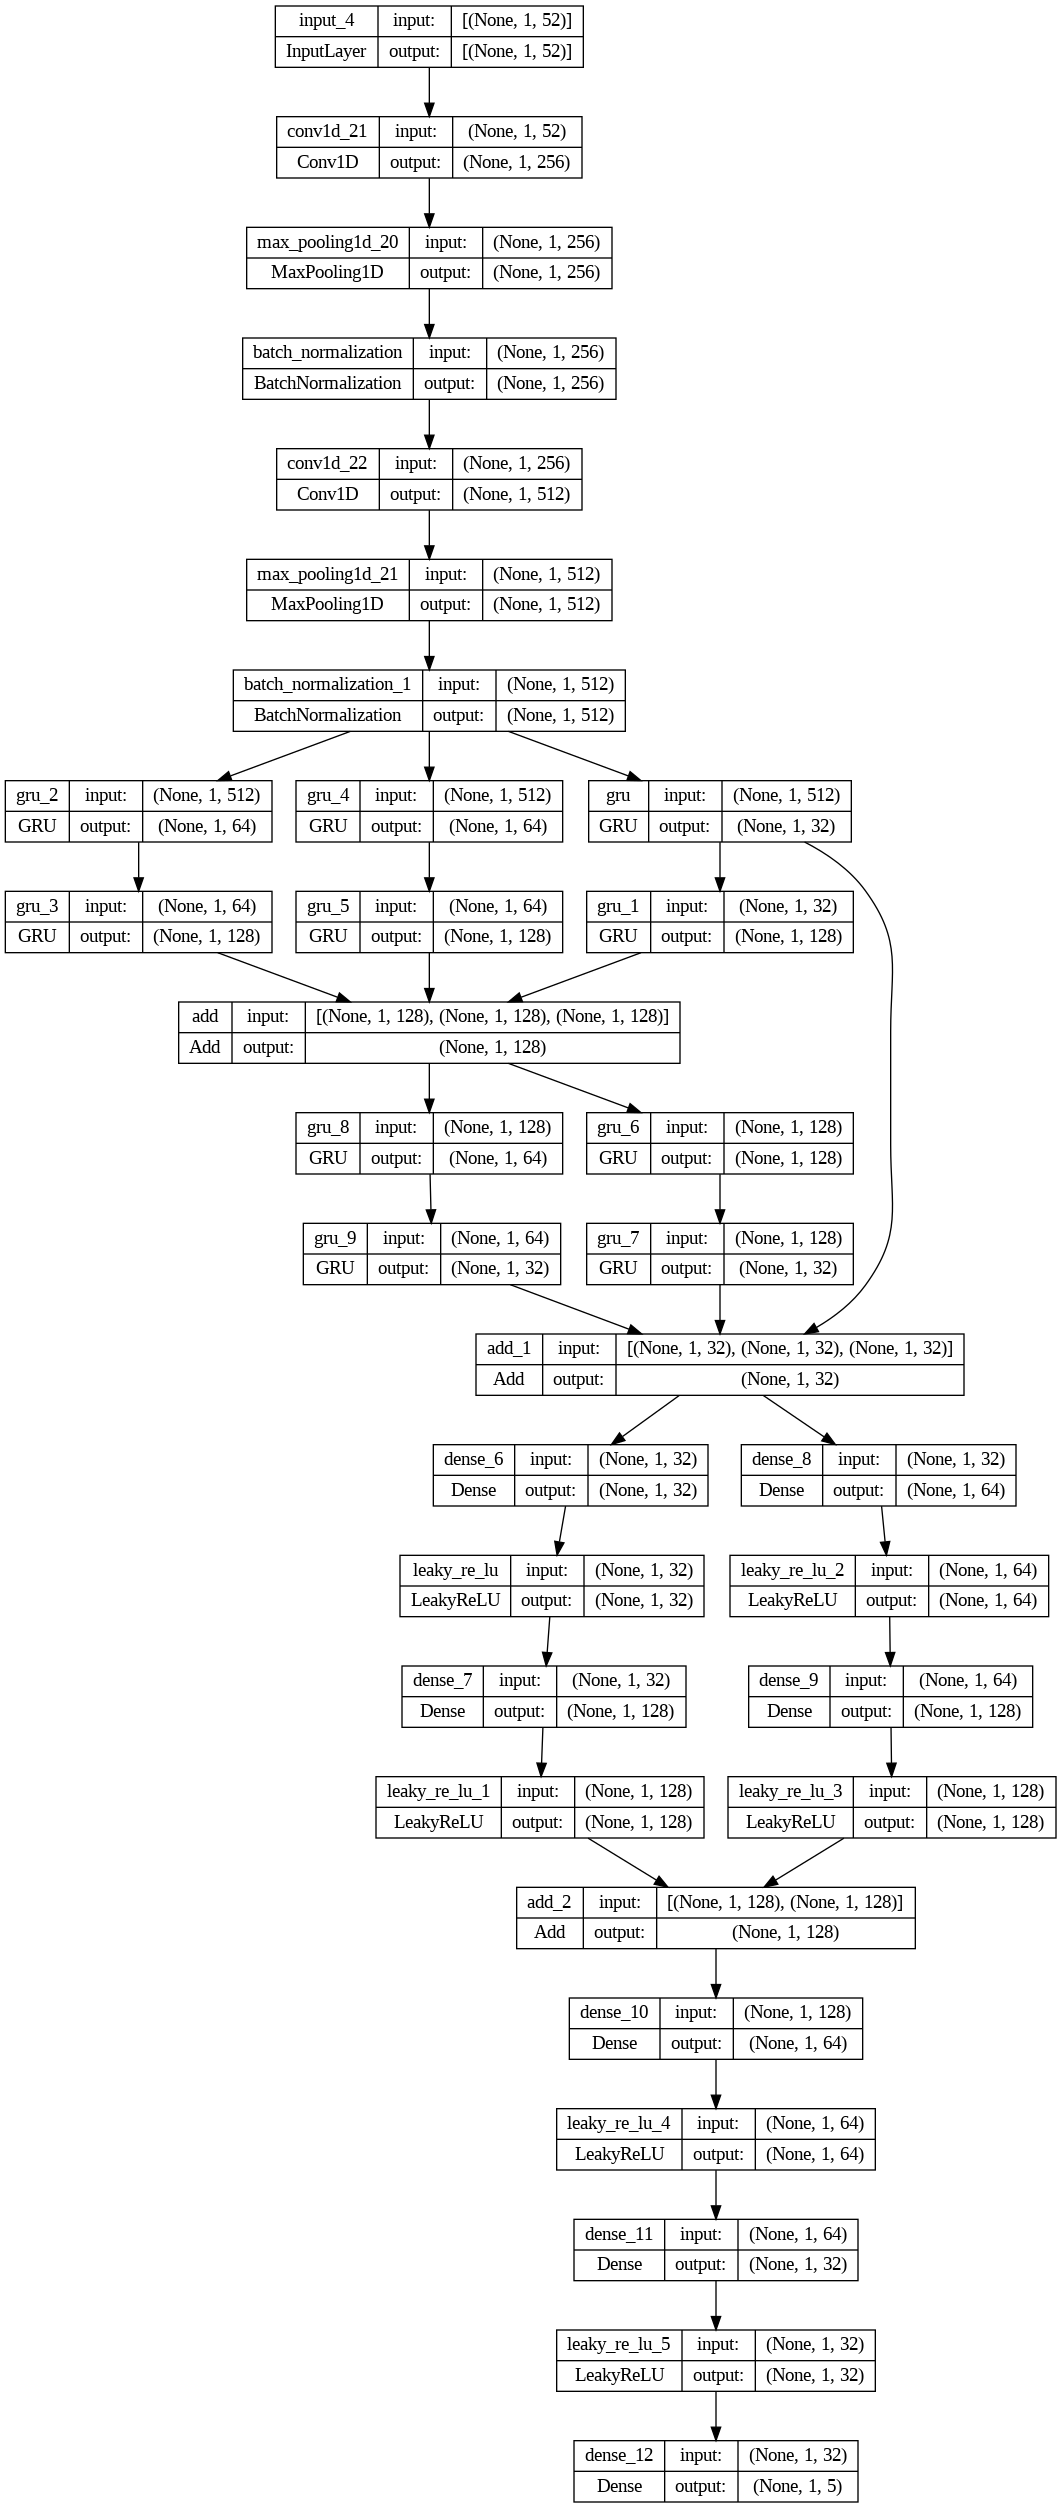

In [ ]:
tf.keras.utils.plot_model(gru_model, "gru_model.png", show_shapes=True)

In [33]:
optimiser = tf.keras.optimizers.Adam(learning_rate = 0.0002)
gru_model.compile(optimizer=optimiser, loss='categorical_crossentropy',metrics=['accuracy'])

cb = [EarlyStopping(patience=300,monitor='accuracy',mode='max',restore_best_weights=True),
      ModelCheckpoint("/content/diagnosis_GRU_CNN_1.h5",save_best_only=True)]

In [34]:
history = gru_model.fit(x_train_gru, y_train_gru, batch_size=8, epochs=150, validation_data=(x_val_gru, y_val_gru), callbacks = cb)

Epoch 1/150
74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.8030 - loss: 0.4292

74/74 ━━━━━━━━━━━━━━━━━━━━ 13s 47ms/step - accuracy: 0.8033 - loss: 0.4293 - val_accuracy: 0.7121 - val_loss: 0.7139
Epoch 2/150
74/74 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - accuracy: 0.7853 - loss: 0.5156 - val_accuracy: 0.6515 - val_loss: 0.8585
Epoch 3/150
72/74 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.8305 - loss: 0.4291

74/74 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - accuracy: 0.8307 - loss: 0.4284 - val_accuracy: 0.7727 - val_loss: 0.6245
Epoch 4/150
74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.8680 - loss: 0.3627

74/74 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - accuracy: 0.8677 - loss: 0.3631 - val_accuracy: 0.8030 - val_loss: 0.4863
Epoch 5/150
74/74 ━━━━━━━━━━━━━━━━━━━━ 3s 33ms/step - accuracy: 0.8539 - loss: 0.3732 - val_accuracy: 0.7424 - val_loss: 0.5665
Epoch 6/150
74/74 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - accuracy: 0.8370 - loss: 0.3733 - val_accuracy: 0.8333 - val_loss: 0.5420
Epoch 7/150
74/74 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - accuracy: 0.8224 - loss: 0.4198 - val_accuracy: 0.7121 - val_loss: 0.5835
Epoch 8/150
74/74 ━━━━━━━━━━━━━━━━━━━━ 3s 23ms/step - accuracy: 0.8360 - loss: 0.3792 - val_accuracy: 0.7879 - val_loss: 0.5645
Epoch 9/150
74/74 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - accuracy: 0.8430 - loss: 0.3624 - val_accuracy: 0.7424 - val_loss: 0.7718
Epoch 10/150
74/74 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - accuracy: 0.8188 - loss: 0.4361 - val_accuracy: 0.8182 - val_loss: 0.6200
Epoch 11/150
74/74 ━━━━━━━━━━━━━━━━━━━━ 3s 34ms/step - accuracy: 0.8572 - loss: 0.3765 - val_accuracy: 0.8030 - val

74/74 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - accuracy: 0.8255 - loss: 0.4171 - val_accuracy: 0.8182 - val_loss: 0.4524
Epoch 27/150
74/74 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - accuracy: 0.8430 - loss: 0.3735 - val_accuracy: 0.8182 - val_loss: 0.4601
Epoch 28/150
74/74 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - accuracy: 0.8898 - loss: 0.2952 - val_accuracy: 0.6818 - val_loss: 0.8724
Epoch 29/150
74/74 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - accuracy: 0.8786 - loss: 0.2905 - val_accuracy: 0.7727 - val_loss: 0.5400
Epoch 30/150
74/74 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - accuracy: 0.8321 - loss: 0.3869 - val_accuracy: 0.7727 - val_loss: 0.7085
Epoch 31/150
74/74 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - accuracy: 0.8340 - loss: 0.3518 - val_accuracy: 0.8182 - val_loss: 0.4910
Epoch 32/150
74/74 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - accuracy: 0.8617 - loss: 0.3311 - val_accuracy: 0.7879 - val_loss: 0.5959
Epoch 33/150
74/74 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - accuracy: 0.8460 - loss: 0.3347 - val_accuracy: 0.7727 

74/74 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - accuracy: 0.8726 - loss: 0.3256 - val_accuracy: 0.8485 - val_loss: 0.4027
Epoch 48/150
74/74 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - accuracy: 0.8383 - loss: 0.3566 - val_accuracy: 0.8182 - val_loss: 0.5809
Epoch 49/150
74/74 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - accuracy: 0.8459 - loss: 0.3530 - val_accuracy: 0.8182 - val_loss: 0.4297
Epoch 50/150
74/74 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - accuracy: 0.8770 - loss: 0.2864 - val_accuracy: 0.8485 - val_loss: 0.5366
Epoch 51/150
74/74 ━━━━━━━━━━━━━━━━━━━━ 3s 36ms/step - accuracy: 0.8605 - loss: 0.3715 - val_accuracy: 0.8333 - val_loss: 0.4634
Epoch 52/150
74/74 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - accuracy: 0.8700 - loss: 0.3580 - val_accuracy: 0.8333 - val_loss: 0.4352
Epoch 53/150
73/74 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.8745 - loss: 0.3140

74/74 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - accuracy: 0.8742 - loss: 0.3142 - val_accuracy: 0.8485 - val_loss: 0.3942
Epoch 54/150
74/74 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - accuracy: 0.8213 - loss: 0.4006 - val_accuracy: 0.6667 - val_loss: 0.9041
Epoch 55/150
74/74 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - accuracy: 0.8426 - loss: 0.3866 - val_accuracy: 0.8636 - val_loss: 0.4657
Epoch 56/150
74/74 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - accuracy: 0.8693 - loss: 0.3096 - val_accuracy: 0.8182 - val_loss: 0.4962
Epoch 57/150
74/74 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - accuracy: 0.8647 - loss: 0.3294 - val_accuracy: 0.8030 - val_loss: 0.6205
Epoch 58/150
74/74 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/step - accuracy: 0.8932 - loss: 0.2733 - val_accuracy: 0.7576 - val_loss: 0.7667
Epoch 59/150
74/74 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - accuracy: 0.8813 - loss: 0.2930 - val_accuracy: 0.8485 - val_loss: 0.4630
Epoch 60/150
74/74 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - accuracy: 0.8302 - loss: 0.4053 - val_accuracy: 0.8030 

74/74 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - accuracy: 0.8567 - loss: 0.3364 - val_accuracy: 0.8939 - val_loss: 0.3746
Epoch 71/150
74/74 ━━━━━━━━━━━━━━━━━━━━ 3s 35ms/step - accuracy: 0.8642 - loss: 0.3175 - val_accuracy: 0.8485 - val_loss: 0.4652
Epoch 72/150
74/74 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - accuracy: 0.8750 - loss: 0.3081 - val_accuracy: 0.7273 - val_loss: 0.7146
Epoch 73/150
74/74 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - accuracy: 0.8720 - loss: 0.3118 - val_accuracy: 0.7121 - val_loss: 0.7678
Epoch 74/150
74/74 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - accuracy: 0.8355 - loss: 0.4239 - val_accuracy: 0.8333 - val_loss: 0.5492
Epoch 75/150
74/74 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - accuracy: 0.8850 - loss: 0.2725 - val_accuracy: 0.7727 - val_loss: 0.9215
Epoch 76/150
74/74 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - accuracy: 0.8560 - loss: 0.2969 - val_accuracy: 0.7879 - val_loss: 0.6092
Epoch 77/150
74/74 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - accuracy: 0.9039 - loss: 0.2390 - val_accuracy: 0.8030 

74/74 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - accuracy: 0.8972 - loss: 0.2545 - val_accuracy: 0.8485 - val_loss: 0.3494


In [35]:
model_name = 'lung_sounds_new.h5'
gru_model.save(model_name, save_format='h5')

In [36]:
Model_Results = gru_model.evaluate(x_train_gru, y_train_gru)
print("LOSS:  " + "%.4f" % Model_Results[0])
print("ACCURACY:  " + "%.4f" % Model_Results[1])

19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.9012 - loss: 0.2441
LOSS:  0.2439
ACCURACY:  0.9096


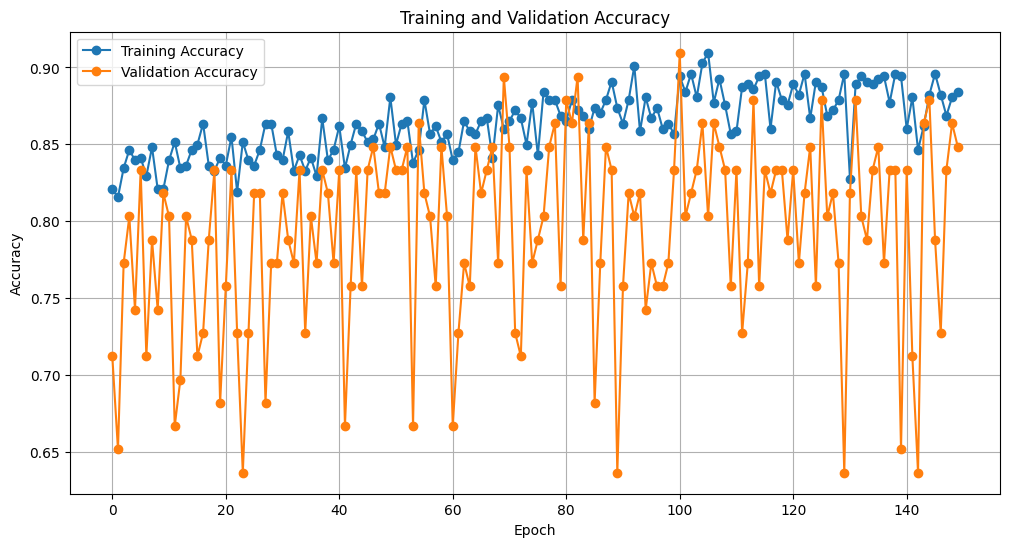

In [37]:
plt.figure(figsize=(12, 6))
plt.plot(history.history['accuracy'], label='Training Accuracy', marker='o')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy', marker='o')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 774ms/step


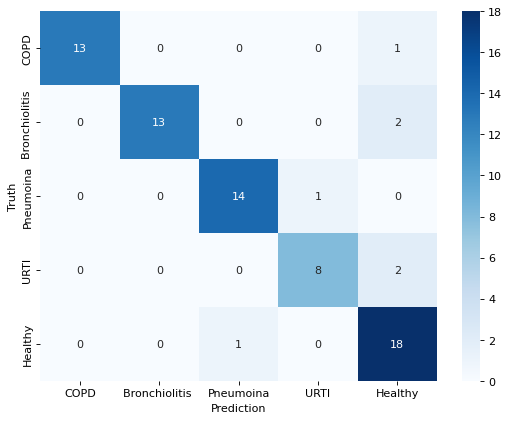

In [38]:
classes = ["COPD" ,"Bronchiolitis ", "Pneumoina", "URTI", "Healthy"]
preds = gru_model.predict(x_test_gru)
classpreds = [np.argmax(t) for t in preds ]
y_testclass = [np.argmax(t) for t in y_test_gru]
cm = confusion_matrix(y_testclass, classpreds)
plt.figure(figsize=(8, 6), dpi=80, facecolor='w', edgecolor='k')
ax = sns.heatmap(cm, cmap='Blues', annot=True, fmt='d', xticklabels=classes, yticklabels=classes)
plt.title('')
plt.xlabel('Prediction')
plt.ylabel('Truth')
plt.show(ax)

In [39]:
print(classification_report(y_testclass, classpreds, target_names=classes))

                precision    recall  f1-score   support

          COPD       1.00      0.93      0.96        14
Bronchiolitis        1.00      0.87      0.93        15
     Pneumoina       0.93      0.93      0.93        15
          URTI       0.89      0.80      0.84        10
       Healthy       0.78      0.95      0.86        19

      accuracy                           0.90        73
     macro avg       0.92      0.90      0.90        73
  weighted avg       0.91      0.90      0.91        73



In [40]:
def gru_diagnosis_prediction(test_audio):
    data_x, sampling_rate = librosa.load(test_audio)
    data_x = stretch (data_x,1.2)

    features = np.mean(librosa.feature.mfcc(y=data_x, sr=sampling_rate, n_mfcc=52).T,axis = 0)

    features = features.reshape(1,52)

    test_pred = gru_model.predict(np.expand_dims(features, axis = 1))
    classpreds = classes[np.argmax(test_pred[0], axis=1)[0]]
    confidence = test_pred.T[test_pred[0].mean(axis=0).argmax()].mean()

    print (classpreds , confidence)

In [41]:
def predict_class(audio_file_path, gru_model, classes, features=52, soundDir=''):
    val = []
    data_x, sampling_rate = librosa.load(audio_file_path + soundDir, res_type='kaiser_fast')
    mfccs = np.mean(librosa.feature.mfcc(y=data_x, sr=sampling_rate, n_mfcc=features).T, axis=0)
    val.append(mfccs)
    val = np.expand_dims(val, axis=1)
    prediction = classes[np.argmax(gru_model.predict(val))]
    print(prediction)
    print('*************')


In [43]:
dir1 = '/content/copd.wav'
predict_class(dir1, gru_model, classes)


/tmp/ipython-input-3290344798.py:3: UserWarning: PySoundFile failed. Trying audioread instead.
  data_x, sampling_rate = librosa.load(audio_file_path + soundDir, res_type='kaiser_fast')


FileNotFoundError: [Errno 2] No such file or directory: '/content/copd.wav'

In [42]:
dir2 = '/content/Healthy.wav'
predict_class(dir2, gru_model, classes)

/tmp/ipython-input-3290344798.py:3: UserWarning: PySoundFile failed. Trying audioread instead.
  data_x, sampling_rate = librosa.load(audio_file_path + soundDir, res_type='kaiser_fast')
/usr/local/lib/python3.12/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)


FileNotFoundError: [Errno 2] No such file or directory: '/content/Healthy.wav'

In [44]:
dir2 = '/content/pneumonia4.wav'
predict_class(dir2, gru_model, classes)

/tmp/ipython-input-3290344798.py:3: UserWarning: PySoundFile failed. Trying audioread instead.
  data_x, sampling_rate = librosa.load(audio_file_path + soundDir, res_type='kaiser_fast')


FileNotFoundError: [Errno 2] No such file or directory: '/content/pneumonia4.wav'

In [45]:
dir1 = '/content/uriti3.wav'
predict_class(dir1, gru_model, classes)


/tmp/ipython-input-3290344798.py:3: UserWarning: PySoundFile failed. Trying audioread instead.
  data_x, sampling_rate = librosa.load(audio_file_path + soundDir, res_type='kaiser_fast')


FileNotFoundError: [Errno 2] No such file or directory: '/content/uriti3.wav'

In [46]:
dir1 = '/content/bronchiolitis.wav'
predict_class(dir1, gru_model, classes)


/tmp/ipython-input-3290344798.py:3: UserWarning: PySoundFile failed. Trying audioread instead.
  data_x, sampling_rate = librosa.load(audio_file_path + soundDir, res_type='kaiser_fast')


FileNotFoundError: [Errno 2] No such file or directory: '/content/bronchiolitis.wav'

In [47]:
dir1 = '/content/bronchiolitis2.wav'
predict_class(dir1, gru_model, classes)


/tmp/ipython-input-3290344798.py:3: UserWarning: PySoundFile failed. Trying audioread instead.
  data_x, sampling_rate = librosa.load(audio_file_path + soundDir, res_type='kaiser_fast')


FileNotFoundError: [Errno 2] No such file or directory: '/content/bronchiolitis2.wav'

In [48]:
dir1 = '/content/bronchiolitis1.wav'
predict_class(dir1, gru_model, classes)


/tmp/ipython-input-3290344798.py:3: UserWarning: PySoundFile failed. Trying audioread instead.
  data_x, sampling_rate = librosa.load(audio_file_path + soundDir, res_type='kaiser_fast')


FileNotFoundError: [Errno 2] No such file or directory: '/content/bronchiolitis1.wav'

In [49]:
dir1 = '/content/Bronchiolitis3.wav'
predict_class(dir1, gru_model, classes)


/tmp/ipython-input-3290344798.py:3: UserWarning: PySoundFile failed. Trying audioread instead.
  data_x, sampling_rate = librosa.load(audio_file_path + soundDir, res_type='kaiser_fast')


FileNotFoundError: [Errno 2] No such file or directory: '/content/Bronchiolitis3.wav'

In [52]:
!pip install streamlit

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.1/10.1 MB 122.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 102.8 MB/s eta 0:00:00


In [66]:
import streamlit as st
import librosa
import numpy as np
from tensorflow.keras.layers import Input, Conv1D, MaxPooling1D, BatchNormalization, GRU, Dense, Dropout, concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.initializers import Orthogonal

classes = ["COPD", "Bronchiolitis", "Pneumonia", "URTI", "Healthy"]

# Custom GRU cell with Orthogonal initializer
def custom_gru(units):
    return GRU(units, recurrent_initializer=Orthogonal())

# Define the model architecture
def build_model(input_shape, num_classes):
    Input_Sample = Input(shape=input_shape)

    model_conv = Conv1D(256, kernel_size=5, strides=1, padding='same', activation='relu')(Input_Sample)
    model_conv = MaxPooling1D(pool_size=2, strides=2, padding='same')(model_conv)
    model_conv = BatchNormalization()(model_conv)

    model_gru_1 = GRU(128, return_sequences=True, activation='tanh', go_backwards=True)(model_conv)

    model_concat = concatenate([model_conv, model_gru_1])

    model_dense_1 = Dense(128, activation='relu')(model_concat)
    model_output = Dense(num_classes, activation='softmax')(model_dense_1)

    model = Model(inputs=Input_Sample, outputs=model_output)
    return model

# Function for loading and predicting with the model
def predict_class(model, classes, uploaded_file, features=52):
    if uploaded_file is not None:
        # Load audio file from file uploader
        with open(uploaded_file.name, "wb") as f:
            f.write(uploaded_file.getbuffer())
        # Load audio data using librosa
        data_x, sampling_rate = librosa.load(uploaded_file.name, res_type='kaiser_fast')
        # Extract features
        mfccs = np.mean(librosa.feature.mfcc(y=data_x, sr=sampling_rate, n_mfcc=features).T, axis=0)
        # Reshape input data to match model's input shape
        val = np.expand_dims(np.expand_dims(mfccs, axis=0), axis=0)
        # Perform prediction
        prediction = classes[np.argmax(model.predict(val))]
        return prediction
    else:
        return "No file uploaded"

# Streamlit UI
def main():
    st.title("Respiratory Disease Diagnosis")
    st.sidebar.title("Options")

    # Build the model
    model = build_model((None, 52), len(classes))

    # Load weights
    model.load_weights("/content/lung_sounds_new.h5")

    # File upload
    uploaded_file = st.sidebar.file_uploader("Upload audio file", type=["wav"])

    if uploaded_file:
        st.audio(uploaded_file, format="audio/wav", start_time=0)

        # Perform prediction when file is uploaded
        if st.sidebar.button("Predict"):
            prediction = predict_class(model, classes, uploaded_file)
            st.write(f"Predicted class: {prediction}")

if __name__ == "__main__":
    main()

2025-10-23 18:57:42.437 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-10-23 18:57:42.437 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-10-23 18:57:42.438 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-10-23 18:57:42.439 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-10-23 18:57:42.441 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-10-23 18:57:42.442 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.


ValueError: Layer count mismatch when loading weights from file. Model expected 5 layers, found 21 saved layers.